This is to find the nash equilibrium of pure strategies of n species and n resources. Each species has their metabolic pathways fixed and can switch among these pathways. Thus, the growth rate is first generated and the preference order can be changed. The gain of each strategy is determined by the net abundance of the species.

In [13]:
# initialization

import numpy as np
import math
import random
import itertools
from scipy.optimize import root
import copy
import time
# set resource number and amount
Nr = 2

# generate species pool: growth rate from gaussian; preference list; invasion order
# growth rates
Res = [1.0, 1.0]
Nb = Nr
Nl = math.factorial(Nr)
g_mean, g_var = 1, 0.2
# budget 8
growth_rate_list = np.exp(np.random.normal(g_mean, math.sqrt(g_var), (Nb, Nr)))
filt = np.heaviside(growth_rate_list, 0)
growth_rate_list = filt*growth_rate_list
budget = 8
growth_rate_list = budget*growth_rate_list / np.sum(growth_rate_list, axis=1)[:, None]
#preference list
preference_list = list(itertools.permutations(range(Nr), Nr))
b0 = 1e-3 # density of bug when introduced/initial
b_threshold = 1e-6 # extinction density
c_threshold = 1e-9 # concentration threshold
# yields
yields_list = 0.5*np.ones([Nb, Nr]) # might need to be modified later?

# dilution parameters 
D = 1e-3
tau = 0 # lag
T_dilute = 10 # time interval between dilutions
dilute_to_steady = 10 # #(dilution) between invasions

In [14]:
def dilute(system, s1, s2): 
    pref_list = [preference_list[s1], preference_list[s2]]
    t_switch = 0
    while t_switch < T_dilute:
        #list of resource in use for each consumer
        use = [0 for i in range(Nb)]
        # list of consumers for each resource
        consumer = [[] for i in range(Nr)]
        for i in range(Nb):
            # if all are depleted, bug still uses its least preferred nutrient
            while system['res_available'][pref_list[i][use[i]]] < 1 and use[i] < Nr - 1:
                use[i] = use[i] + 1
            if system['bug_available'][i] > 0:
                consumer[pref_list[i][use[i]]].append(i)
        # find the earliest depleted resource
        t_dep = T_dilute - t_switch
        for i in range(Nr):
            if system['res_available'][i] > 0:
                def remain(t):  
                    # S = c - sum(B0(e^gt-1)/Y)                
                    return system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                    #print(consumer[0])
                # a little bit tricky here...
                t_i = root(remain, T_dilute + 1).x[0]
                if t_i < t_dep:
                    t_dep = t_i
        # update the system according to this t_dep
        t_switch = t_switch + t_dep
        temp_bug_density = [i for i in system['bug_density']]
        for i in range(Nb):
            if system['res_available'][pref_list[i][use[i]]] > 0:
                temp_bug_density[i] = system['bug_density'][i]*math.exp(growth_rate_list[i][pref_list[i][use[i]]]*t_dep)
        for i in range(Nr):
            if system['res_available'][i] > 0:
                system['res_concentration'][i] = system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t_dep*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                if system['res_concentration'][i] < c_threshold: 
                    system['res_available'][i] = 0
        for i in range(Nb):
            system['bug_density'][i] = temp_bug_density[i]
    #print(system)
    #print("diluted once")
    return system
        
def move_to_new(system):
    system['bug_density'] = [(i*D > b_threshold)*i*D for i in system['bug_density']]
    system['bug_available'] = [1*(system['bug_density'][i] > b_threshold) for i in range(Nb)]
    system['res_concentration'] = [(system['res_concentration'][i]*D + Res[i]) / (D + 1) for i in range(Nr)]
    system['res_available'] = [1*(system['res_concentration'][i] > c_threshold) for i in range(Nr)]
    return system

def isNE(s1, s2, pay1, pay2):
    for i in range(Nl):
        if pay1[i, s2] > pay1[s1, s2]: return False
    for j in range(Nl):
        if pay2[s1, j] > pay2[s1, s2]: return False
    return True

In [8]:
# generate the matrices

pay1 = np.zeros([2, 2])
pay2 = np.zeros([2, 2])
for s1 in range(Nl):
    for s2 in range(Nl):
        system = {'res_available': [1, 1], 'res_concentration': [1.0, 1.0], 'bug_available': [1, 1], 'bug_density': [b0, 0.1*b0]}
        for i in range(dilute_to_steady):
            system = dilute(system, s1, s2)
            system = move_to_new(system)
        system = dilute(system, s1, s2)
        pay1[s1, s2] = system['bug_density'][0]
        pay2[s1, s2] = system['bug_density'][1]

# find NE
NE = []
for s1 in range(Nl):
    for s2 in range(Nl):             
        if isNE(s1, s2, pay1, pay2) == True:
            NE.append([s1, s2])

In [9]:
system = {'res_available': [1, 1], 'res_concentration': [1.0, 1.0], 'bug_available': [1, 1], 'bug_density': [b0, b0]}
system = dilute(system, 1, 1)
system

{'res_available': [0, 0],
 'res_concentration': [-2.220446049250313e-16, 4.440892098500626e-16],
 'bug_available': [1, 1],
 'bug_density': [0.7044686789750797, 0.2975313210249202]}

In [149]:
growth_rate_list

array([[3.70826584, 4.29173416],
       [2.03678252, 5.96321748]])

In [170]:
NE

[[1, 0]]

In [151]:
pay1

array([[1.000001, 0.      ],
       [1.000001, 0.      ]])

In [152]:
pay2

array([[0.      , 1.000001],
       [0.      , 1.000001]])

The above is the case for 2 species. Now try 3 species and 3 resources. 

In [11]:
# initialization

import numpy as np
import math
import random
import itertools
from scipy.optimize import root, fsolve
import copy
import time

Res = [1.0, 1.0, 1.0]
Nr = 3
Nb = Nr
Nl = math.factorial(Nr)
g_mean, g_var = 1, 0.4
# budget 8
growth_rate_list = np.exp(np.random.normal(g_mean, math.sqrt(g_var), (Nb, Nr)))
filt = np.heaviside(growth_rate_list, 0)
growth_rate_list = filt*growth_rate_list
budget = 6
growth_rate_list = budget*growth_rate_list / np.sum(growth_rate_list, axis=1)[:, None]
#preference list
preference_list = list(itertools.permutations(range(Nr), Nr))
b0 = 1e-3 # density of bug when introduced/initial
b_threshold = 1e-6 # extinction density
c_threshold = 1e-9 # concentration threshold
# yields
yields_list = 0.5*np.ones([Nb, Nr]) # might need to be modified later?

# dilution parameters 
D = 1e-3
tau = 0 # lag
T_dilute = 10 # time interval between dilutions
dilute_to_steady = 15 # #(dilution) between invasions

In [12]:
def dilute(system, s1, s2, s3): 
    pref_list = [preference_list[s1], preference_list[s2], preference_list[s3]]
    t_switch = 0
    while t_switch < T_dilute:
        #list of resource in use for each consumer
        use = [0 for i in range(Nb)]
        # list of consumers for each resource
        consumer = [[] for i in range(Nr)]
        for i in range(Nb):
            # if all are depleted, bug still uses its least preferred nutrient
            while system['res_available'][pref_list[i][use[i]]] < 1 and use[i] < Nr - 1:
                use[i] = use[i] + 1
            if system['bug_available'][i] > 0:
                consumer[pref_list[i][use[i]]].append(i)
        # find the earliest depleted resource
        t_dep = T_dilute - t_switch
        for i in range(Nr):
            if system['res_available'][i] > 0:
                def remain(t):  
                    # S = c - sum(B0(e^gt-1)/Y)   
                    return system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                # a little bit tricky here...
                t_i = root(remain, T_dilute + 1).x[0]
                if t_i < t_dep:
                    t_dep = t_i
        # update the system according to this t_dep
        t_switch = t_switch + t_dep
        temp_bug_density = [i for i in system['bug_density']]
        for i in range(Nb):
            if system['res_available'][pref_list[i][use[i]]] > 0:
                temp_bug_density[i] = system['bug_density'][i]*math.exp(growth_rate_list[i][pref_list[i][use[i]]]*t_dep)
        for i in range(Nr):
            if system['res_available'][i] > 0:
                system['res_concentration'][i] = system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t_dep*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                #print(system['res_concentration'])
                if system['res_concentration'][i] < c_threshold: 
                    system['res_available'][i] = 0
        for i in range(Nb):
            system['bug_density'][i] = temp_bug_density[i]
    #print(system)
    #print("diluted once")
    return system
        
def move_to_new(system):
    system['bug_density'] = [(i*D > b_threshold)*i*D for i in system['bug_density']]
    system['bug_available'] = [1*(system['bug_density'][i] > b_threshold) for i in range(Nb)]
    system['res_concentration'] = [(system['res_concentration'][i]*D + Res[i]) / (D + 1) for i in range(Nr)]
    system['res_available'] = [1*(system['res_concentration'][i] > c_threshold) for i in range(Nr)]
    return system

def isNE(s1, s2, s3, pay1, pay2, pay3):
    for i in range(Nl):
        if pay1[i, s2, s3] > pay1[s1, s2, s3]: return False
    for i in range(Nl):
        if pay2[s1, i, s3] > pay2[s1, s2, s3]: return False
    for i in range(Nl):
        if pay3[s1, s2, i] > pay3[s1, s2, s3]: return False
    if pay1[s1, s2, s3]==0 or pay2[s1, s2, s3]==0 or pay3[s1, s2, s3]==0: return False
    return True

def test(growth_rate_list, system, s1, s2, s3):
    for i in range(dilute_to_steady):
        system = dilute(system, s1, s2, s3)
        system = move_to_new(system)
    system = dilute(system, s1, s2, s3)
    system['bug_density'] = [((i-0.05)>0)*i for i in system['bug_density']]
    system['bug_available'] = [system['bug_available'][i]*(system['bug_density'][i]>0) for i in range(Nb)]
    system = move_to_new(system)
    system = dilute(system, s1, s2, s3)
    return system

In [114]:
# generate the matrices
start = time.time()

pay1 = np.zeros((Nl, Nl, Nl))
pay2 = np.zeros((Nl, Nl, Nl))
pay3 = np.zeros((Nl, Nl, Nl))
for s1 in range(Nl):
    for s2 in range(Nl):
        print('check')
        for s3 in range(Nl):
            system = {'res_available': [1, 1, 1], 'res_concentration': [1.0, 1.0, 1.0], 'bug_available': [1, 1, 1], 'bug_density': [b0, b0, b0]}
            system = test(growth_rate_list, system, s1, s2, s3)
            pay1[s1, s2, s3] = system['bug_density'][0]
            pay2[s1, s2, s3] = system['bug_density'][1]
            pay3[s1, s2, s3] = system['bug_density'][2]

# find NE
NE = []
for s1 in range(Nl):
    for s2 in range(Nl):    
        for s3 in range(Nl):
            if isNE(s1, s2, s3, pay1, pay2, pay3) == True:
                NE.append([s1, s2, s3])
                
end = time.time()
print(end-start)

check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
4.300495147705078


In [9]:
growth_rate_list_cop = copy.deepcopy(growth_rate_list)

In [94]:
system = {'res_available': [1, 1, 1], 'res_concentration': [1.0, 1.0, 1.0], 'bug_available': [1, 1, 1], 'bug_density': [b0, b0, b0]}
system = test(growth_rate_list, system, 1, 4, 3)
system

{'res_available': [0, 0, 0],
 'res_concentration': [1.1102230246251565e-16,
  -4.440892098500626e-16,
  -5.773159728050814e-15],
 'bug_available': [1, 1, 1],
 'bug_density': [1.0075286709219569, 0.4845600883575534, 0.007912740721993026]}

In [115]:
NE

[]

In [106]:
for i in range(100):
    system = move_to_new(system)
    system = dilute(system, 1, 4, 3)
system

{'res_available': [0, 0, 0],
 'res_concentration': [-1.3322676295501878e-15,
  -3.3306690738754696e-16,
  -8.881784197001252e-15],
 'bug_available': [1, 1, 0],
 'bug_density': [1.0071270912607184, 0.4928744087407871, 0.0]}

In [122]:
system = move_to_new(system)
system

{'res_available': [1, 1, 1],
 'res_concentration': [0.9981952201378186,
  0.9990009990015898,
  0.9988575397651553],
 'bug_available': [0, 1, 0],
 'bug_density': [0.0, 0.002684614521340522, 0.0]}

In [163]:
preference_list

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

In [65]:
growth_rate_list

array([[3.61981173, 0.553335  , 1.82685327],
       [2.72771565, 1.84286648, 1.42941788],
       [3.26537186, 2.03510534, 0.6995228 ]])

In [92]:
dilute_to_steady

30

Try to draw a diagram, where I try combinations of growth rates within the budget. First try with 2 nutrients and 2 bugs.

In [1]:
# initialization

import numpy as np
import math
import random
import itertools
from scipy.optimize import root
import copy
import time
import matplotlib.pyplot as plt
# set resource number and amount
Nr = 2

# generate species pool: growth rate from gaussian; preference list; invasion order
# growth rates
Res = [1.0, 1.0]
Nb = Nr
Nl = math.factorial(Nr)

#preference list
preference_list = list(itertools.permutations(range(Nr), Nr))
b0 = 1e-3 # density of bug when introduced/initial
b_threshold = 1e-6 # extinction density
c_threshold = 1e-9 # concentration threshold
# yields
yields_list = 0.5*np.ones([Nb, Nr]) # might need to be modified later?

# dilution parameters 
D = 1e-3
tau = 0 # lag
T_dilute = 10 # time interval between dilutions
dilute_to_steady = 10 # #(dilution) between invasions

In [32]:
def dilute(system, s1, s2): 
    pref_list = [preference_list[s1], preference_list[s2]]
    t_switch = 0
    while t_switch < T_dilute:
        #list of resource in use for each consumer
        use = [0 for i in range(Nb)]
        # list of consumers for each resource
        consumer = [[] for i in range(Nr)]
        for i in range(Nb):
            # if all are depleted, bug still uses its least preferred nutrient
            while system['res_available'][pref_list[i][use[i]]] < 1 and use[i] < Nr - 1:
                use[i] = use[i] + 1
            if system['bug_available'][i] > 0:
                consumer[pref_list[i][use[i]]].append(i)
        # find the earliest depleted resource
        t_dep = T_dilute - t_switch
        for i in range(Nr):
            if system['res_available'][i] > 0:
                def remain(t):  
                    # S = c - sum(B0(e^gt-1)/Y)                
                    return system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                    #print(consumer[0])
                # a little bit tricky here...
                t_i = root(remain, T_dilute + 1).x[0]
                if t_i < t_dep:
                    t_dep = t_i
        # update the system according to this t_dep
        t_switch = t_switch + t_dep
        temp_bug_density = [i for i in system['bug_density']]
        for i in range(Nb):
            if system['res_available'][pref_list[i][use[i]]] > 0:
                temp_bug_density[i] = system['bug_density'][i]*math.exp(growth_rate_list[i][pref_list[i][use[i]]]*t_dep)
        for i in range(Nr):
            if system['res_available'][i] > 0:
                system['res_concentration'][i] = system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t_dep*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                if system['res_concentration'][i] < c_threshold: 
                    system['res_available'][i] = 0
        for i in range(Nb):
            system['bug_density'][i] = temp_bug_density[i]
    #print(system)
    #print("diluted once")
    return system
        
def move_to_new(system):
    system['bug_density'] = [(i*D > b_threshold)*i*D for i in system['bug_density']]
    system['bug_available'] = [1*(system['bug_density'][i] > b_threshold) for i in range(Nb)]
    system['res_concentration'] = [(system['res_concentration'][i]*D + Res[i]) / (D + 1) for i in range(Nr)]
    system['res_available'] = [1*(system['res_concentration'][i] > c_threshold) for i in range(Nr)]
    return system

def isNE(s1, s2, pay1, pay2):
    for i in range(Nl):
        if pay1[i, s2] > pay1[s1, s2]: return False
    for j in range(Nl):
        if pay2[s1, j] > pay2[s1, s2]: return False
    if pay1[s1, s2]*pay2[s1, s2] == 0:return False
    return True

In [33]:
# generate the matrices
start = time.time()
budget = 8
scale = 8
NEs = np.zeros([budget*scale, budget*scale])
NE_records = []
for g11 in range(budget*scale):
    print(g11)
    for g21 in range(budget*scale):
        growth_rate_list = np.zeros([2, 2])
        growth_rate_list[0][0] = g11/scale
        growth_rate_list[0][1] = budget - g11/scale
        growth_rate_list[1][0] = g21/scale
        growth_rate_list[1][1] = budget - g21/scale
        
        pay1 = np.zeros([2, 2])
        pay2 = np.zeros([2, 2])
        for s1 in range(Nl):
            for s2 in range(Nl):
                system = {'res_available': [1, 1], 'res_concentration': [1.0, 1.0], 'bug_available': [1, 1], 'bug_density': [b0, b0]}
                for i in range(dilute_to_steady):
                    system = dilute(system, s1, s2)
                    system = move_to_new(system)
                system = dilute(system, s1, s2)
                pay1[s1, s2] = round(system['bug_density'][0], 5)
                pay2[s1, s2] = round(system['bug_density'][1], 5)

        # find NE
        NE = []
        for s1 in range(Nl):
            for s2 in range(Nl):             
                if isNE(s1, s2, pay1, pay2) == True:
                    NE.append([s1, s2])
                    
        NEs[g11, g21] = len(NE)
        NE_records.append((g11, g21, NE, pay1, pay2))
        
end = time.time()
end-start

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


150.39692544937134

Text(0,0.5,'g21')

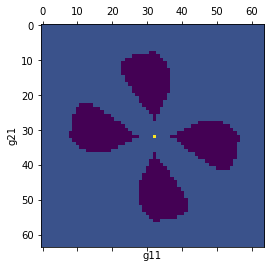

In [34]:
plt.matshow(NEs)
plt.xlabel('g11')
plt.ylabel('g21')

In [27]:
pay1 = np.zeros([2, 2])
pay2 = np.zeros([2, 2])
growth_rate_list = [[31/8, 33/8], [10/8, 54/8]]
system = {'res_available': [1, 1], 'res_concentration': [1.0, 1.0], 'bug_available': [1, 1], 'bug_density': [b0, b0]}
s1 = 0
s2 = 0
for i in range(dilute_to_steady):
    system = dilute(system, s1, s2)
    system = move_to_new(system)
system = dilute(system, s1, s2)
pay1[s1, s2] = round(system['bug_density'][0], 5)
pay2[s1, s2] = round(system['bug_density'][1], 5)
pay1

array([[1., 0.],
       [0., 0.]])

In [31]:
NE_records[671]

(10, 31, [[1, 0], [1, 1]], array([[0., 0.],
        [1., 1.]]), array([[1., 1.],
        [0., 0.]]))

In [18]:
growth_rate_list = np.array([[4, 4], [4, 4]])
for s1 in range(Nl):
    for s2 in range(Nl):
        system = {'res_available': [1, 1], 'res_concentration': [1.0, 1.0], 'bug_available': [1, 1], 'bug_density': [b0, b0]}
        for i in range(dilute_to_steady):
            system = dilute(system, s1, s2)
            system = move_to_new(system)
        system = dilute(system, s1, s2)
        pay1[s1, s2] = system['bug_density'][0]
        pay2[s1, s2] = system['bug_density'][1]
#isNE(1, 0, pay1, pay2)
pay2[0]-pay2[1]

array([ 1.11022302e-16, -1.11022302e-16])

the above needs some understand, too hungry to think, let's look at 3 nutrients

In [35]:
# initialization

import numpy as np
import math
import random
import itertools
from scipy.optimize import root, fsolve
import matplotlib.pyplot as plt
import copy
import time

Res = [1.0, 1.0, 1.0]
Nr = 3
Nb = Nr
Nl = math.factorial(Nr)
g_mean, g_var = 1, 0.4
# budget 8
growth_rate_list = np.exp(np.random.normal(g_mean, math.sqrt(g_var), (Nb, Nr)))
filt = np.heaviside(growth_rate_list, 0)
growth_rate_list = filt*growth_rate_list
budget = 6
growth_rate_list = budget*growth_rate_list / np.sum(growth_rate_list, axis=1)[:, None]
#preference list
preference_list = list(itertools.permutations(range(Nr), Nr))
b0 = 1e-3 # density of bug when introduced/initial
b_threshold = 1e-6 # extinction density
c_threshold = 1e-9 # concentration threshold
# yields
yields_list = 0.5*np.ones([Nb, Nr]) # might need to be modified later?

# dilution parameters 
D = 1e-3
tau = 0 # lag
T_dilute = 10 # time interval between dilutions
dilute_to_steady = 15 # #(dilution) between invasions

In [36]:
def dilute(system, s1, s2, s3): 
    pref_list = [preference_list[s1], preference_list[s2], preference_list[s3]]
    t_switch = 0
    while t_switch < T_dilute:
        #list of resource in use for each consumer
        use = [0 for i in range(Nb)]
        # list of consumers for each resource
        consumer = [[] for i in range(Nr)]
        for i in range(Nb):
            # if all are depleted, bug still uses its least preferred nutrient
            while system['res_available'][pref_list[i][use[i]]] < 1 and use[i] < Nr - 1:
                use[i] = use[i] + 1
            if system['bug_available'][i] > 0:
                consumer[pref_list[i][use[i]]].append(i)
        # find the earliest depleted resource
        t_dep = T_dilute - t_switch
        for i in range(Nr):
            if system['res_available'][i] > 0:
                def remain(t):  
                    # S = c - sum(B0(e^gt-1)/Y)   
                    return system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                # a little bit tricky here...
                t_i = root(remain, T_dilute + 1).x[0]
                if t_i < t_dep:
                    t_dep = t_i
        # update the system according to this t_dep
        t_switch = t_switch + t_dep
        temp_bug_density = [i for i in system['bug_density']]
        for i in range(Nb):
            if system['res_available'][pref_list[i][use[i]]] > 0:
                temp_bug_density[i] = system['bug_density'][i]*math.exp(growth_rate_list[i][pref_list[i][use[i]]]*t_dep)
        for i in range(Nr):
            if system['res_available'][i] > 0:
                system['res_concentration'][i] = system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t_dep*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                #print(system['res_concentration'])
                if system['res_concentration'][i] < c_threshold: 
                    system['res_available'][i] = 0
        for i in range(Nb):
            system['bug_density'][i] = temp_bug_density[i]
    #print(system)
    #print("diluted once")
    return system
        
def move_to_new(system):
    system['bug_density'] = [(i*D > b_threshold)*i*D for i in system['bug_density']]
    system['bug_available'] = [1*(system['bug_density'][i] > b_threshold) for i in range(Nb)]
    system['res_concentration'] = [(system['res_concentration'][i]*D + Res[i]) / (D + 1) for i in range(Nr)]
    system['res_available'] = [1*(system['res_concentration'][i] > c_threshold) for i in range(Nr)]
    return system

def isNE(s1, s2, s3, pay1, pay2, pay3):
    for i in range(Nl):
        if pay1[i, s2, s3] > pay1[s1, s2, s3]: return False
    for i in range(Nl):
        if pay2[s1, i, s3] > pay2[s1, s2, s3]: return False
    for i in range(Nl):
        if pay3[s1, s2, i] > pay3[s1, s2, s3]: return False
    if pay1[s1, s2, s3]==0 or pay2[s1, s2, s3]==0 or pay3[s1, s2, s3]==0: return False
    return True

def test(growth_rate_list, system, s1, s2, s3):
    for i in range(dilute_to_steady):
        system = dilute(system, s1, s2, s3)
        system = move_to_new(system)
    system = dilute(system, s1, s2, s3)
    system['bug_density'] = [((i-0.05)>0)*i for i in system['bug_density']]
    system['bug_available'] = [system['bug_available'][i]*(system['bug_density'][i]>0) for i in range(Nb)]
    system = move_to_new(system)
    system = dilute(system, s1, s2, s3)
    return system

In [40]:
# This is where I test how could k affect the result. 
budget = 8

allGR = []
allNE = []
Nl = 6
for i in range(10):

    # generate the matrices
    start = time.time()
    nSamples = 10
    #NEs = np.zeros([budget*scale, budget*scale])
    GRlist = []
    NEslist = []
    paylist = []

    for idx in range(nSamples):
        #glist = np.random.rand(3, 3)
        glist = np.random.rand(3, 3)+np.identity(3)*i*0.3
        row_sums = glist.sum(axis=1)
        growth_rate_list = glist / row_sums[:, np.newaxis] * budget
        pay1 = np.zeros((Nl, Nl, Nl))
        pay2 = np.zeros((Nl, Nl, Nl))
        pay3 = np.zeros((Nl, Nl, Nl))
        for s1 in range(Nl):
            for s2 in range(Nl):
                #print('check')
                for s3 in range(Nl):
                    system = {'res_available': [1, 1, 1], 'res_concentration': [1.0, 1.0, 1.0], 'bug_available': [1, 1, 1], 'bug_density': [b0, b0, b0]}
                    system = test(growth_rate_list, system, s1, s2, s3)
                    pay1[s1, s2, s3] = system['bug_density'][0]
                    pay2[s1, s2, s3] = system['bug_density'][1]
                    pay3[s1, s2, s3] = system['bug_density'][2]

        # find NE
        NE = []
        for s1 in range(Nl):
            for s2 in range(Nl):    
                for s3 in range(Nl):
                    if isNE(s1, s2, s3, pay1, pay2, pay3) == True:
                        NE.append([s1, s2, s3])
        GRlist.append(growth_rate_list)
        NEslist.append(NE)
        #print(idx)
        #paylist.append(pay1)

    end = time.time()
    print(i)
    print(end-start)
    allGR.append(GRlist)
    allNE.append(NEslist)


0
59.517467975616455
1
52.40873098373413
2
53.01411175727844
3
54.28734469413757
4
60.51978802680969
5
95.12860679626465
6
66.39272570610046
7
73.36382603645325
8
67.72985625267029
9
77.92083978652954


In [41]:
%store allNE
%store allGR
NEslist

Stored 'allNE' (list)
Stored 'allGR' (list)


[[[0, 2, 4], [0, 2, 5], [1, 2, 4], [1, 2, 5]],
 [[0, 2, 4], [0, 2, 5], [1, 2, 4], [1, 2, 5]],
 [[0, 2, 5], [0, 3, 5], [1, 2, 5], [1, 3, 5]],
 [[1, 2, 4], [1, 2, 5], [1, 3, 4], [1, 3, 5]],
 [[1, 2, 4], [1, 2, 5], [1, 3, 4], [1, 3, 5]],
 [[0, 2, 4], [0, 2, 5], [0, 3, 4], [0, 3, 5]],
 [[0, 2, 4], [0, 2, 5], [1, 2, 4], [1, 2, 5]],
 [[0, 2, 4], [0, 3, 4], [1, 2, 4], [1, 3, 4]],
 [[0, 2, 4], [0, 3, 4], [1, 2, 4], [1, 3, 4]],
 [[0, 2, 5], [0, 3, 5], [1, 2, 5], [1, 3, 5]]]

[]
[[6.36534644 0.64757927 0.98707429]
 [1.7132649  5.87708086 0.40965424]
 [1.04334813 1.34985358 5.6067983 ]]


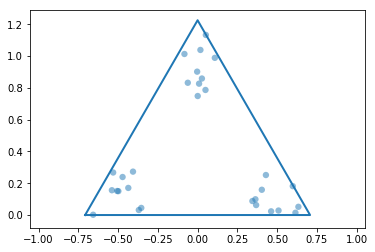

In [20]:

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_triangle(A, B, C):
    x = [A[0], B[0], C[0], A[0]]
    y = [A[1], B[1], C[1], A[1]]
    ax = plt.gca()
    ax.plot(x, y, linewidth=2)

def draw_circle(x, y, r):
    ax = plt.gca()
    cir = Circle(xy=(x, y), radius=r, alpha=0.5)
    ax.add_patch(cir)
    ax.plot()
    
def project(data):
    draw_circle((data[0][1]-data[0][0])/math.sqrt(2)/sum(data[0]), data[0][2]*math.sqrt(6)/2/sum(data[0]), 0.02)
    draw_circle((data[1][1]-data[1][0])/math.sqrt(2)/sum(data[1]), data[1][2]*math.sqrt(6)/2/sum(data[1]), 0.02)
    draw_circle((data[2][1]-data[2][0])/math.sqrt(2)/sum(data[2]), data[2][2]*math.sqrt(6)/2/sum(data[2]), 0.02)
    
plt.axis('equal')
plot_triangle([-math.sqrt(2)/2, 0], [math.sqrt(2)/2, 0], [0, math.sqrt(6)/2])
#draw_circle((output(system)[3][0][1]-output(system)[3][0][0])/math.sqrt(2)/8, output(system)[3][0][2]*math.sqrt(6)/16, 0.02)
for GR in GRlist:
    project(GR)
a = []
for idx, i in enumerate(NEslist):
    if len(i)>0: a.append(idx)
print(a)
print(GRlist[1])# I should just randomly generate groups of growth rates and save them with the corresponding NEs. 

In [138]:
budget = 8

# generate the matrices
def NEFind(k, nSamples):
    start = time.time()
    GRlist_1 = []
    NEslist_1 = []
    #paylist_1 = []

    for idx in range(nSamples):
        glist = np.random.rand(3, 3)+k*np.identity(3)
        #glist = np.random.rand(3, 3)+np.identity(3)*5
        row_sums = glist.sum(axis=1)
        growth_rate_list = glist / row_sums[:, np.newaxis] * budget
        pay1 = np.zeros((Nl, Nl, Nl))
        pay2 = np.zeros((Nl, Nl, Nl))
        pay3 = np.zeros((Nl, Nl, Nl))
        for s1 in range(Nl):
            for s2 in range(Nl):
                #print('check')
                for s3 in range(Nl):
                    system = {'res_available': [1, 1, 1], 'res_concentration': [1.0, 1.0, 1.0], 'bug_available': [1, 1, 1], 'bug_density': [b0, b0, b0]}
                    system = test(growth_rate_list, system, s1, s2, s3)
                    pay1[s1, s2, s3] = system['bug_density'][0]
                    pay2[s1, s2, s3] = system['bug_density'][1]
                    pay3[s1, s2, s3] = system['bug_density'][2]

        # find NE
        NE = []
        for s1 in range(Nl):
            for s2 in range(Nl):    
                for s3 in range(Nl):
                    if isNE(s1, s2, s3, pay1, pay2, pay3) == True:
                        NE.append([s1, s2, s3])
        GRlist_1.append(growth_rate_list)
        NEslist_1.append(NE)
        print(idx)
        print(NEslist_1)
        #paylist.append(pay1)

    end = time.time()
    print(end-start)
    return GRlist_1, NEslist_1, pay1, pay2, pay3

In [196]:
GRlist_1

[array([[5.43044264, 1.43099831, 1.13855905],
        [1.79351505, 5.59129159, 0.61519335],
        [1.60486273, 1.52931749, 4.86581978]])]

In [24]:
pay2

array([[[0.41729732, 0.41729732],
        [0.49116249, 0.49116249]],

       [[1.000001  , 1.000001  ],
        [1.000001  , 1.000001  ]]])

In [1]:
# I should just randomly generate groups of growth rates and save them with the corresponding NEs. 
glist = [[1.0, 2.0, 3.0], [1.0, 3.0, 2.0], [2.0, 1.0, 3.0], [2.0, 3.0, 1.0], [3.0, 1.0, 2.0], [3.0, 2.0, 1.0], [2.0, 2.0, 2.0]]

def dilute(system, pref1, pref2, pref3, s1, s2, s3): 
    growth_rate_list = [glist[s1], glist[s2], glist[s3]]
    pref_list = [preference_list[pref1], preference_list[pref2], preference_list[pref3]]
    t_switch = 0
    while t_switch < T_dilute:
        #list of resource in use for each consumer
        use = [0 for i in range(Nb)]
        # list of consumers for each resource
        consumer = [[] for i in range(Nr)]
        for i in range(Nb):
            # if all are depleted, bug still uses its least preferred nutrient
            while system['res_available'][pref_list[i][use[i]]] < 1 and use[i] < Nr - 1:
                use[i] = use[i] + 1
            if system['bug_available'][i] > 0:
                consumer[pref_list[i][use[i]]].append(i)
        # find the earliest depleted resource
        t_dep = T_dilute - t_switch
        for i in range(Nr):
            if system['res_available'][i] > 0:
                def remain(t):  
                    # S = c - sum(B0(e^gt-1)/Y)   
                    return system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                # a little bit tricky here...
                t_i = root(remain, T_dilute + 1).x[0]
                if t_i < t_dep:
                    t_dep = t_i
        # update the system according to this t_dep
        t_switch = t_switch + t_dep
        temp_bug_density = [i for i in system['bug_density']]
        for i in range(Nb):
            if system['res_available'][pref_list[i][use[i]]] > 0:
                temp_bug_density[i] = system['bug_density'][i]*math.exp(growth_rate_list[i][pref_list[i][use[i]]]*t_dep)
        for i in range(Nr):
            if system['res_available'][i] > 0:
                system['res_concentration'][i] = system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t_dep*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                #print(system['res_concentration'])
                if system['res_concentration'][i] < c_threshold: 
                    system['res_available'][i] = 0
        for i in range(Nb):
            system['bug_density'][i] = temp_bug_density[i]
    #print(system)
    #print("diluted once")
    return system

def test(system, pref1, pref2, pref3, s1, s2, s3):
    for i in range(dilute_to_steady):
        system = dilute(system, pref1, pref2, pref3, s1, s2, s3)
        system = move_to_new(system)
    system = dilute(system, pref1, pref2, pref3, s1, s2, s3)
    system['bug_density'] = [((i-0.05)>0)*i for i in system['bug_density']]
    system['bug_available'] = [system['bug_available'][i]*(system['bug_density'][i]>0) for i in range(Nb)]
    system = move_to_new(system)
    system = dilute(system, pref1, pref2, pref3, s1, s2, s3)
    return system

def isNE(s1, s2, s3, pay1, pay2, pay3):
    for i in range(Nl):
        if pay1[i, s2, s3] > pay1[s1, s2, s3]: return False
    for i in range(Nl):
        if pay2[s1, i, s3] > pay2[s1, s2, s3]: return False
    for i in range(Nl):
        if pay3[s1, s2, i] > pay3[s1, s2, s3]: return False
    if pay1[s1, s2, s3]==0 or pay2[s1, s2, s3]==0 or pay3[s1, s2, s3]==0: return False
    return True

start = time.time()
nSamples = 6*6*6
NEs = np.zeros([budget*scale, budget*scale])
PFlist = []
NEslist_2 = []
paylist_2 = []
Nl = 7

for pref1 in range(6):
    for pref2 in range(6):
        print(pref2)
        for pref3 in range(6):
            pay1 = np.zeros((Nl, Nl, Nl))
            pay2 = np.zeros((Nl, Nl, Nl))
            pay3 = np.zeros((Nl, Nl, Nl))
            for s1 in range(7):
                for s2 in range(7):
                    #print('check')
                    for s3 in range(7):
                        system = {'res_available': [1, 1, 1], 'res_concentration': [1.0, 1.0, 1.0], 'bug_available': [1, 1, 1], 'bug_density': [b0, b0, b0]}
                        system = test(system, pref1, pref2, pref3, s1, s2, s3)
                        pay1[s1, s2, s3] = system['bug_density'][0]
                        pay2[s1, s2, s3] = system['bug_density'][1]
                        pay3[s1, s2, s3] = system['bug_density'][2]

            # find NE
            NE = []
            for s1 in range(Nl):
                for s2 in range(Nl):    
                    for s3 in range(Nl):
                        if isNE(s1, s2, s3, pay1, pay2, pay3) == True:
                            NE.append([s1, s2, s3])
            PFlist.append([preference_list[pref1],preference_list[pref2], preference_list[pref3]])
            NEslist_2.append(NE)
            #print(idx)
            #paylist_2.append(pay1)
        
end = time.time()
end-start

NameError: name 'time' is not defined

In [170]:
%store NEslist_2
%store PFlist

Stored 'NEslist_2' (list)
Stored 'PFlist' (list)


In [185]:
import collections

In [176]:
pref1, pref2, pref3 = 0, 2, 4
for s1 in range(7):
    for s2 in range(7):
        #print('check')
        for s3 in range(7):
            system = {'res_available': [1, 1, 1], 'res_concentration': [1.0, 1.0, 1.0], 'bug_available': [1, 1, 1], 'bug_density': [b0, b0, b0]}
            system = test(system, pref1, pref2, pref3, s1, s2, s3)
            pay1[s1, s2, s3] = system['bug_density'][0]
            pay2[s1, s2, s3] = system['bug_density'][1]
            pay3[s1, s2, s3] = system['bug_density'][2]

In [194]:
a = [len(i)+random.randint(-50, 50)/100 for i in NEslist_2]

def getEntropy(list0):
    d = collections.Counter(list0)
    freqs = [d[i] for i in list0]
    summed = sum(freqs)
    return sum(-(i/summed)*math.log(i/summed) for i in freqs)

b = [getEntropy([elem[0] for elem in i])+random.randint(-50, 50)/10000 for i in PFlist]

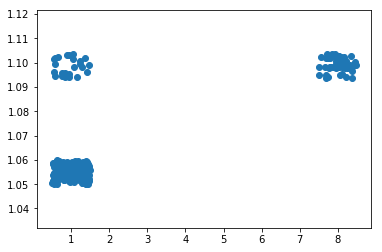

In [195]:
plt.scatter(a, b)

In [4]:
a = [1]
a.append((1, 2))
a

[1, (1, 2)]